In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import os, json
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import matplotlib.pyplot as plt

import go_bench
from go_bench.load_tools import load_GO_tsv_file, load_protein_sequences, convert_to_sparse_matrix

from go_metric.data_utils import *
from go_metric.models.bottleneck_dpg_conv import DPGModule
from scipy.sparse import csr_matrix, csc_matrix, dok_matrix, vstack, hstack
from sklearn.metrics import precision_recall_fscore_support

In [29]:
from go_metric.models.tars_model import TARSModule
model = TARSModule.load_from_checkpoint("checkpoints/tars-model-v2.ckpt")
model.eval()
device = torch.device('cuda:0')
model.to(device)
print("model loaded")

#Load OWL embeddings
import pickle
with open("/home/andrew/go_metric/data/owl_emb/3-L-R-2-50", "rb") as f:
    embeddings = pickle.load(f, encoding="bytes")
owl_terms = [a[0].split(r'/')[-1].replace("_", ":") for a in embeddings]
owl_mat = np.array([a[1] for a in embeddings])
import json
train_path = "/home/andrew/go_metric/data/go_bench"
with open(f"{train_path}/molecular_function_terms.json") as f:
    train_terms = json.load(f)
with open(f"{train_path}/testing_molecular_function_terms.json") as f:
    test_terms = json.load(f)
go_emb = torch.FloatTensor(map_embeddings(train_terms, owl_terms, owl_mat))
test_go_emb = torch.FloatTensor(map_embeddings(test_terms, owl_terms, owl_mat))

model loaded
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero
default zero


In [8]:
train_path = "/home/andrew/go_metric/data/go_bench"
train_dataset = TermDataset.from_pickle(f"{train_path}/train.pkl")
val_dataset = TermDataset.from_pickle(f"{train_path}/val.pkl")
test_dataset = TermDataset.from_pickle(f"{train_path}/val.pkl")


collate_seqs = get_bert_seq_collator(max_length=1024, add_special_tokens=False)
dataloader_params = {"shuffle": False, "batch_size": 256, "collate_fn":collate_seqs}
val_dataloader_params = {"shuffle": False, "batch_size": 256, "collate_fn":collate_seqs}

train_loader = DataLoader(train_dataset.seq_dataset, **dataloader_params)
val_loader = DataLoader(val_dataset.seq_dataset, **val_dataloader_params)
test_loader = DataLoader(test_dataset.seq_dataset, **val_dataloader_params)

In [31]:
def get_tars_preds(tars_model, dataloader, term_emb, threshold=0.02):
    device = tars_model.device
    term_emb = term_emb.to(device)
    prot_ids = []
    probs_list = []
    with torch.no_grad():
        for d in dataloader:
            prot_id_l = d["prot_id"]
            X = d["seq"]
            mask = d["mask"] 
            prot_ids.extend(prot_id_l)
            X = X.to(device)
            mask = mask.to(device)
            # print(X.shape, mask.shape)
            te = torch.tile(term_emb.view(1, -1), (X.shape[0], 1))
            # print(te.shape)
            m_probs = tars_model.forward(X, mask, te)
            m_probs = torch.softmax(m_probs, dim=1)
            m_probs = m_probs.cpu().numpy()
            m_probs = np.where(m_probs > threshold, m_probs, 0) #Threshold unlikely predictions to keep output sparse. 
            probs_list.append(m_probs)
    probs = np.concatenate(probs_list, axis=0)
    return prot_ids, probs

In [32]:
# term_ids = [1, 3, 7, 10, 20, 30, 40, 55, 70, 80, 100, 130, 150, 200, 250, 300, 350, 400, 500, 600]
term_ids = [10, 20, 50, 70, 210, 570]
term_probs = []
for term_id in term_ids:
    term_emb = go_emb[term_id]
    prot_ids, probs = get_tars_preds(model, val_loader, term_emb)
    term_probs.append(probs[:, 1:])
term_probs = np.concatenate(term_probs, axis=1)

# term_ids = list(range(300, 3000, 100))
# term_probs = []
# for term_id in term_ids:
#     term_emb = test_go_emb[term_id]
#     prot_ids, probs = get_tars_preds(model, val_loader, term_emb)
#     term_probs.append(probs[:, 1:])
# term_probs = np.concatenate(term_probs, axis=1)

In [53]:
def get_sparse_probs(model, dataloader, threshold=0.02):
    prot_ids = []
    probs_list = []
    with torch.no_grad():
        for d in dataloader:
            prot_id_l = d["prot_id"]
            X = d["seq"]
            prot_ids.extend(prot_id_l)
            X = X.to(device)
            m_probs = model(X)
            # torch.sigmoid(m_probs, out=m_probs)
            m_probs = m_probs.cpu().numpy()
            # m_probs = np.where(m_probs > threshold, m_probs, 0) #Threshold unlikely predictions to keep output sparse. 
            # new_probs = csr_matrix(m_probs, dtype=np.float32)
            probs_list.append(m_probs)
    probs = np.vstack(probs_list)
    return prot_ids, probs

In [54]:
from go_metric.models.bottleneck_dpg_conv import DPGModule
model = DPGModule.load_from_checkpoint("checkpoints/bottleneck_128.ckpt")
model.eval()
device = torch.device('cuda:1')
model.to(device)

Lightning automatically upgraded your loaded checkpoint from v1.7.3 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file checkpoints/bottleneck_128.ckpt`


DPGModule(
  (model): DPGConvSeq(
    (conv1): Conv1d(30, 128, kernel_size=(3,), stride=(1,), padding=same)
    (dropout): Dropout(p=0.5, inplace=False)
    (nets): ModuleList(
      (0): BaseFilter(
        (conv): Conv1d(128, 800, kernel_size=(8,), stride=(1,), padding=valid)
        (pool): MaxPool1d(kernel_size=1017, stride=1017, padding=0, dilation=1, ceil_mode=False)
        (relu): ReLU()
      )
      (1): BaseFilter(
        (conv): Conv1d(128, 800, kernel_size=(16,), stride=(1,), padding=valid)
        (pool): MaxPool1d(kernel_size=1009, stride=1009, padding=0, dilation=1, ceil_mode=False)
        (relu): ReLU()
      )
      (2): BaseFilter(
        (conv): Conv1d(128, 800, kernel_size=(24,), stride=(1,), padding=valid)
        (pool): MaxPool1d(kernel_size=1001, stride=1001, padding=0, dilation=1, ceil_mode=False)
        (relu): ReLU()
      )
      (3): BaseFilter(
        (conv): Conv1d(128, 800, kernel_size=(32,), stride=(1,), padding=valid)
        (pool): MaxPool1d(ke

In [55]:
# test_ids, test_probs = get_sparse_probs(model, test_loader)
ml_val_ids, ml_val_probs = get_sparse_probs(model, val_loader)
ml_val_sample_probs = ml_val_probs[:, term_ids]

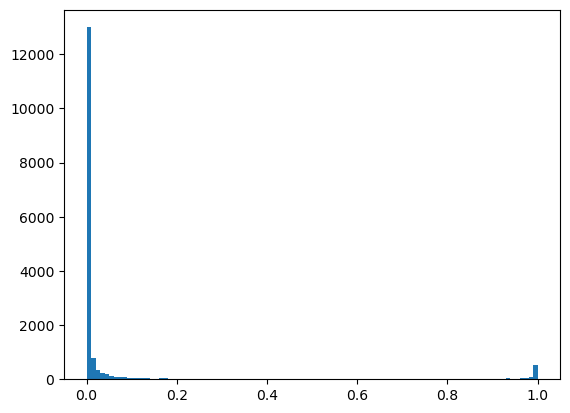

In [62]:
plt.hist(1 / (1 + np.exp(-ml_val_sample_probs[:, 0])), bins=100)
plt.show()

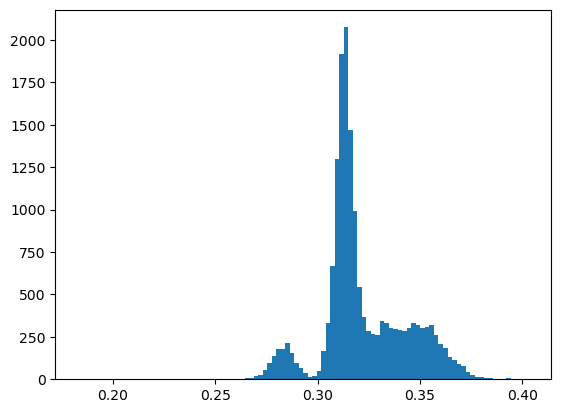

In [70]:
plt.hist(term_probs[:, 5], bins=100)
plt.show()
# plt.hist(torch.sigmoid(torch.FloatTensor(ml_val_sample_probs[:, 3])), bins=100)

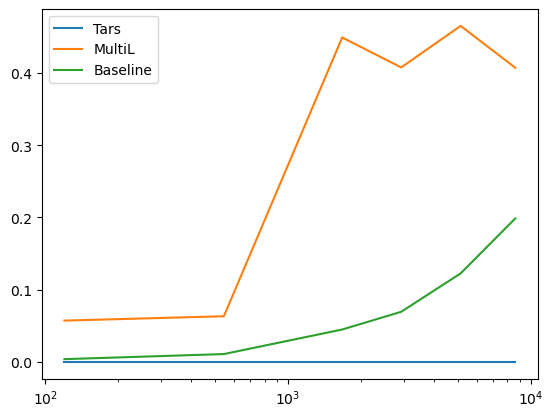

In [45]:
from sklearn.metrics import f1_score
labels = val_dataset.seq_dataset.labels.toarray()
preds_dict = {"Tars": term_probs, "MultiL": ml_val_sample_probs, "Baseline": np.ones(term_probs.shape)}

preds_f1 = {key: [] for key in preds_dict.keys()}
for mkey, preds in preds_dict.items():
    for i, term_id in enumerate(term_ids):
        term_labels = labels[:, term_id]
        f1 = f1_score(term_labels, preds[:, i] > 0.99)
        preds_f1[mkey].append(f1)

term_frequencies = train_dataset.seq_dataset.labels.toarray().sum(axis=0)
for mkey, mf1 in preds_f1.items():
    plt.plot(term_frequencies[term_ids], mf1)
plt.legend(preds_dict.keys())
plt.xscale('log')
plt.show()

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [24]:
from sklearn.metrics import f1_score
labels = val_dataset.seq_dataset.labels.toarray()
term_labels = labels[:, term_id].astype(int)
f1 = f1_score(term_labels, probs[:, 1] > 0.1)
print("F1 Score", f1)

F1 Score 0.033912084083386564


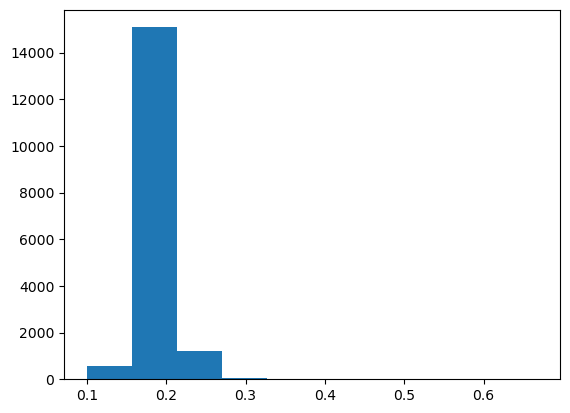

In [12]:
plt.hist(probs[:, 1])
plt.show()

In [14]:
f1 = f1_score(term_labels, term_labels*0+1)
print("F1 Score", f1)

F1 Score 0.033908146083725256


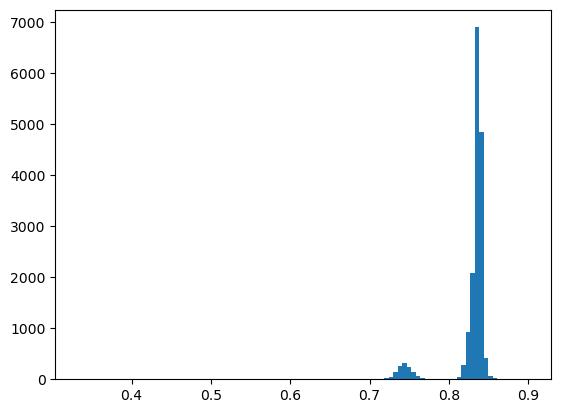

In [53]:
plt.hist(probs[:, 0], bins=100)
plt.show()

In [ ]:
f1_score = 

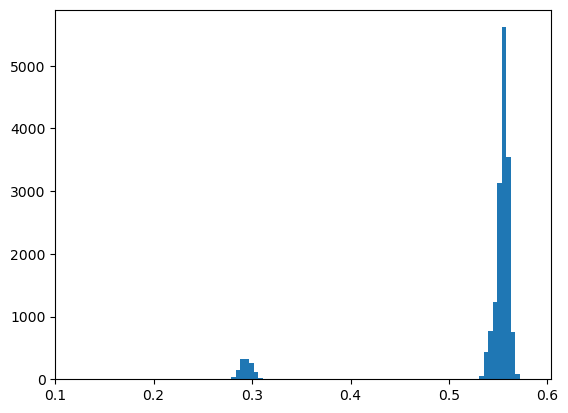

In [9]:
plt.hist(probs[:, 0], bins=100)
plt.show()